In [43]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.ml.stat import Correlation
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as f

In [2]:
sc.stop()

NameError: name 'sc' is not defined

In [253]:
# Initializing a Spark session

conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=appName, master=local) created by __init__ at <ipython-input-3-904c66fc6d91>:4 

# Data Ingestion

In [4]:
raw_data = spark.read.format("csv").option("header","true").option("inferSchema", "true").load(r"sulbha.ss.csv")
raw_data.columns

['AnonPuid',
 'Product_new_group_update',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'tot_Usage_Engagement',
 'Usage_Others',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Others_Pass',
 'Usage_MMTV',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music']

## Product_new_group_update = Target Group
## tot_cnt =  # of visits
## PI_... = Page impression, share of among all product cateory visit
## total_usage_engagement = time spent of site
## Usage_ ... = time spent on that product

In [5]:
raw_data.printSchema()

root
 |-- AnonPuid: integer (nullable = true)
 |-- Product_new_group_update: string (nullable = true)
 |-- tot_cnt: integer (nullable = true)
 |-- PI_Others: double (nullable = true)
 |-- PI_Productivity_App: double (nullable = true)
 |-- PI_Entertainment_App: double (nullable = true)
 |-- PI_Casual_game: double (nullable = true)
 |-- PI_Core_game: double (nullable = true)
 |-- PI_Others_OperatingSystem: double (nullable = true)
 |-- PI_Others_Pass: double (nullable = true)
 |-- PI_MMTV: double (nullable = true)
 |-- PI_Other_App: double (nullable = true)
 |-- PI_Others_Device: double (nullable = true)
 |-- PI_Others_Bundle: double (nullable = true)
 |-- PI_Others_Music: integer (nullable = true)
 |-- tot_Usage_Engagement: integer (nullable = true)
 |-- Usage_Others: integer (nullable = true)
 |-- Usage_Productivity_App: integer (nullable = true)
 |-- Usage_Entertainment_App: integer (nullable = true)
 |-- Usage_Casual_game: integer (nullable = true)
 |-- Usage_Core_game: integer (null

In [6]:
pd.DataFrame(raw_data.take(5), columns = raw_data.columns).transpose()

,0,1,2,3,4
AnonPuid,1,2,3,4,5
Product_new_group_update,Others,Others,Productivity_App,Entertainment_App,Others
tot_cnt,3,1,1,13,18
PI_Others,1,1,0,0.923077,0.5
PI_Productivity_App,0,0,1,0.384615,0.222222
PI_Entertainment_App,0,0,0,0.461538,0
PI_Casual_game,0,0,0,0.230769,0
PI_Core_game,0,0,0,0,0.277778
PI_Others_OperatingSystem,0,0,0,0,0
PI_Others_Pass,0,0,0,0,0


In [7]:
raw_data.groupBy("Product_new_group_update").count().toPandas()

,Product_new_group_update,count
0,Productivity_App,45
1,MMTV,2
2,Others_Pass,3
3,Casual_game,17
4,Core_game,14
5,Others_Operating System,3
6,Others,279
7,Entertainment_App,29


## Let's consider - 'Others' , 'Productivity_App', 'Entertainment_App'

In [8]:
d = raw_data.select('*').where((raw_data.Product_new_group_update =='Productivity_App') | (raw_data.Product_new_group_update =='Others') | (raw_data.Product_new_group_update =='Entertainment_App')).collect()
data1 = spark.createDataFrame(d,raw_data.columns )

In [10]:
data1.groupBy('Product_new_group_update').count().toPandas()

,Product_new_group_update,count
0,Productivity_App,45
1,Others,279
2,Entertainment_App,29


## Exploratory Data Analysis -
### 1. Convert target label to binary/multinomial class
### 2. Data Summary: Statistical description i.e. mean, std dev etc.
### 3. Data Cleaning - Drop minuscule features 
### 4. Detect Outliers and remove
#### 4.i - Data Imputation for features which are mostly 0 (30% are non-zero) so filling 0's as mean 
### 5. Feature Selection - Correlation and p-value 

In [11]:
data1.columns

['AnonPuid',
 'Product_new_group_update',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'tot_Usage_Engagement',
 'Usage_Others',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Others_Pass',
 'Usage_MMTV',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music']

### 1. Convert target label to binary/multinomial class

In [12]:
data2 = data1.withColumn("label_New", lit(-1))

data2 = data2\
.withColumn('label_New',when(data2['Product_new_group_update'] == 'Others',0).otherwise(data2.label_New))

data2 = data2\
.withColumn('label_New',when(data2['Product_new_group_update'] == 'Productivity_App',1).otherwise(data2.label_New))

data2 = data2\
.withColumn('label_New',when(data2['Product_new_group_update'] == 'Entertainment_App',2).otherwise(data2.label_New))

data2\
.select(col('label_New').alias('label'),col('*'))\
.toPandas().head(5)

,label,AnonPuid,Product_new_group_update,tot_cnt,PI_Others,PI_Productivity_App,PI_Entertainment_App,PI_Casual_game,PI_Core_game,PI_Others_OperatingSystem,...,Usage_Casual_game,Usage_Core_game,Usage_Others_OperatingSystem,Usage_Others_Pass,Usage_MMTV,Usage_Other_App,Usage_Others_Device,Usage_Others_Bundle,Usage_Others_Music,label_New
0,0,1,Others,3,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,2,Others,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,292642266,0,0,0,106185,0,0,0,0,0
2,1,3,Productivity_App,1,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
3,2,4,Entertainment_App,13,0.923077,0.384615,0.461538,0.230769,0.000000,0.0,...,9609,0,0,0,23422314,0,0,0,0,2
4,0,5,Others,18,0.500000,0.222222,0.000000,0.000000,0.277778,0.0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# drop categorical target variable
data2 = data2.drop('Product_new_group_update')
print (data2.columns)
print (data2.toPandas().head(5))

['AnonPuid', 'tot_cnt', 'PI_Others', 'PI_Productivity_App', 'PI_Entertainment_App', 'PI_Casual_game', 'PI_Core_game', 'PI_Others_OperatingSystem', 'PI_Others_Pass', 'PI_MMTV', 'PI_Other_App', 'PI_Others_Device', 'PI_Others_Bundle', 'PI_Others_Music', 'tot_Usage_Engagement', 'Usage_Others', 'Usage_Productivity_App', 'Usage_Entertainment_App', 'Usage_Casual_game', 'Usage_Core_game', 'Usage_Others_OperatingSystem', 'Usage_Others_Pass', 'Usage_MMTV', 'Usage_Other_App', 'Usage_Others_Device', 'Usage_Others_Bundle', 'Usage_Others_Music', 'label_New']
   AnonPuid  tot_cnt  PI_Others  PI_Productivity_App  PI_Entertainment_App  \
0         1        3   1.000000             0.000000              0.000000   
1         2        1   1.000000             0.000000              0.000000   
2         3        1   0.000000             1.000000              0.000000   
3         4       13   0.923077             0.384615              0.461538   
4         5       18   0.500000             0.222222       

## 2. Find data summary

In [66]:
exclude_cols = ['AnonPuid', 'label_New']
corr_cols = [c for c in  data2.columns if c not in exclude_cols]

data_corr =  data1.select(corr_cols)
data_corr.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
tot_cnt,353,9.444759206798867,14.326466766543549,1,161
PI_Others,353,0.7737874180906517,0.30406380942832406,0.0,1.0
PI_Productivity_App,353,0.17564524852974508,0.2661814164952494,0.0,1.0
PI_Entertainment_App,353,0.16602384354107652,0.2550527491729801,0.0,1.0
PI_Casual_game,353,0.11297854711898016,0.21130988820872706,0.0,1.0
PI_Core_game,353,0.0654968802549575,0.15919261067517118,0.0,1.0
PI_Others_OperatingSystem,353,0.0025368562322946177,0.030002123819534012,0.0,0.5
PI_Others_Pass,353,0.011444561512747876,0.07149547116124849,0.0,1.0
PI_MMTV,353,0.006490084674220964,0.0394291304013073,0.0,0.333333333


## 3. Data Cleaning - Drop minuscule features 

In [75]:
drop_cols = ['Usage_Others', 'Usage_Others_OperatingSystem', 'Usage_Other_App', 'Usage_Others_Device', 'Usage_Others_Bundle',\
             'Usage_Others_Music','PI_Others_Music']
data_corr = data_corr.select([c for c in data_corr.columns if c not in drop_cols])
data_corr.columns

['tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'tot_Usage_Engagement',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_Pass',
 'Usage_MMTV']

## 4. Detect Outliers and removal

In [76]:
## check outliers based on IQR distance

bounds = {
    c: dict(
        zip(["q1", "q3"], data_corr.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in data_corr.columns
}

for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
print(bounds)

{'tot_cnt': {'q1': 2.0, 'q3': 11.0, 'lower': -11.5, 'upper': 24.5}, 'PI_Others': {'q1': 0.666666667, 'q3': 1.0, 'lower': 0.16666666749999998, 'upper': 1.4999999995}, 'PI_Productivity_App': {'q1': 0.0, 'q3': 0.25, 'lower': -0.375, 'upper': 0.625}, 'PI_Entertainment_App': {'q1': 0.0, 'q3': 0.258064516, 'lower': -0.38709677400000003, 'upper': 0.6451612900000001}, 'PI_Casual_game': {'q1': 0.0, 'q3': 0.166666667, 'lower': -0.2500000005, 'upper': 0.4166666675}, 'PI_Core_game': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'PI_Others_OperatingSystem': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'PI_Others_Pass': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'PI_MMTV': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'PI_Other_App': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'PI_Others_Device': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'PI_Others_Bundle': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'tot_Usage_Engagement': {'q1': 512348.0, 'q3':

In [95]:
# Mark rows within 1 IQR + 3IQR as 0(No-Outlier) else 1(Outlier). New feature ending with '_out' is created. 
data_outlier = data2.select(
    "*",
    *[
        f.when(
            f.col(c).between(bounds[c]['lower'], bounds[c]['upper']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in data_corr.columns
    ]
)
data_outlier.columns

['AnonPuid',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'tot_Usage_Engagement',
 'Usage_Others',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Others_Pass',
 'Usage_MMTV',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music',
 'label_New',
 'tot_cnt_out',
 'PI_Others_out',
 'PI_Productivity_App_out',
 'PI_Entertainment_App_out',
 'PI_Casual_game_out',
 'PI_Core_game_out',
 'PI_Others_OperatingSystem_out',
 'PI_Others_Pass_out',
 'PI_MMTV_out',
 'PI_Other_App_out',
 'PI_Others_Device_out',
 'PI_Others_Bundle_out',
 'tot_Usage_Engagement_out',
 'Usage_Productivity_App_out',
 'Usage_Entertainment_App_out',
 'Usage_Casual_game_out',
 'Usage_Core_game_out',
 

In [96]:
# explore how many rows have outliered data.
out_lst = []
for i in data_outlier.columns:
    if i.endswith('_out'):
        out_lst.append(i)
        print (i + ' has ' + str(data_outlier.filter( data_outlier[i]==1).count()))


tot_cnt_out has 27
PI_Others_out has 31
PI_Productivity_App_out has 24
PI_Entertainment_App_out has 24
PI_Casual_game_out has 34
PI_Core_game_out has 82
PI_Others_OperatingSystem_out has 6
PI_Others_Pass_out has 20
PI_MMTV_out has 16
PI_Other_App_out has 14
PI_Others_Device_out has 8
PI_Others_Bundle_out has 3
tot_Usage_Engagement_out has 49
Usage_Productivity_App_out has 52
Usage_Entertainment_App_out has 54
Usage_Casual_game_out has 86
Usage_Core_game_out has 31
Usage_Others_Pass_out has 38
Usage_MMTV_out has 86


In [28]:
data_outlier.count()

353

In [122]:
data_corr.select('PI_Core_game').agg(avg('PI_Core_game')).first()

Row(avg(PI_Core_game)=0.0654968802549575)

In [131]:
# some features have lots of outliers~ 30%, which might result in data loss so not drop .. instead impute with mean value   
do_not_drop_outlier= ['PI_Core_game_out','Usage_Casual_game_out','Usage_MMTV_out']
expr = ' and '.join('(%s == 0)' % col_name for col_name in out_lst if col_name not in do_not_drop_outlier)
expr


'(tot_cnt_out == 0) and (PI_Others_out == 0) and (PI_Productivity_App_out == 0) and (PI_Entertainment_App_out == 0) and (PI_Casual_game_out == 0) and (PI_Others_OperatingSystem_out == 0) and (PI_Others_Pass_out == 0) and (PI_MMTV_out == 0) and (PI_Other_App_out == 0) and (PI_Others_Device_out == 0) and (PI_Others_Bundle_out == 0) and (tot_Usage_Engagement_out == 0) and (Usage_Productivity_App_out == 0) and (Usage_Entertainment_App_out == 0) and (Usage_Core_game_out == 0) and (Usage_Others_Pass_out == 0)'

In [84]:
data_outlier.filter(expr).count()

130

In [85]:
data_outlier.count()

353

In [141]:
data_outlier = data_outlier.filter(expr)
data_outlier.count()

130

In [142]:
data_outlier.columns

['AnonPuid',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'tot_Usage_Engagement',
 'Usage_Others',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Others_Pass',
 'Usage_MMTV',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music',
 'label_New',
 'tot_cnt_out',
 'PI_Others_out',
 'PI_Productivity_App_out',
 'PI_Entertainment_App_out',
 'PI_Casual_game_out',
 'PI_Core_game_out',
 'PI_Others_OperatingSystem_out',
 'PI_Others_Pass_out',
 'PI_MMTV_out',
 'PI_Other_App_out',
 'PI_Others_Device_out',
 'PI_Others_Bundle_out',
 'tot_Usage_Engagement_out',
 'Usage_Productivity_App_out',
 'Usage_Entertainment_App_out',
 'Usage_Casual_game_out',
 'Usage_Core_game_out',
 

## 4.i Data Imputation

In [156]:
impute_cols = ['PI_Core_game','Usage_Casual_game','Usage_MMTV']

#data2 = data2\
#.withColumn('label_New',when(data2['Product_new_group_update'] == 'Others',0).otherwise(data2.label_New))
data_impute = data_outlier

for c in impute_cols:
    expr = c+'_out==1'
    mean_val = data_impute.select(c).filter(expr).agg(avg(c)).first()[0]
    data_impute = data_impute.withColumn(c+"_impute", lit(-1))
    data_impute = data_impute \
         .withColumn(c+"_impute", when(data_impute[c+'_out']==0, mean_val).otherwise(data2[c]))

data_impute.describe().toPandas()        

,summary,AnonPuid,tot_cnt,PI_Others,PI_Productivity_App,PI_Entertainment_App,PI_Casual_game,PI_Core_game,PI_Others_OperatingSystem,PI_Others_Pass,...,tot_Usage_Engagement_out,Usage_Productivity_App_out,Usage_Entertainment_App_out,Usage_Casual_game_out,Usage_Core_game_out,Usage_Others_Pass_out,Usage_MMTV_out,PI_Core_game_impute,Usage_Casual_game_impute,Usage_MMTV_impute
0,count,130,130,130,130,130,130,130,130,130,...,130,130,130,130,130,130,130,130,130,130
1,mean,193.9923076923077,5.407692307692308,0.8935948700307691,0.09121324132307694,0.0892481933076923,0.04160819725384615,0.04334522202307693,0.0,0.0,...,0.0,0.0,0.0,0.12307692307692308,0.0,0.0,0.2,0.37565859086666586,8807797.1875,633544.9615384624
2,stddev,110.64998212842542,4.976995379279221,0.18367445272933172,0.16438197512092093,0.15668158572841964,0.09568144747192882,0.14580148020300984,0.0,0.0,...,0.0,0.0,0.0,0.32979638104700215,0.0,0.0,0.40154739455949573,0.08211098851965536,4447215.2926106835,627661.5711860895
3,min,1,1,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0.071428571,82626.0,1500.0
4,max,388,22,1.0,0.6,0.5,0.4,1.0,0.0,0.0,...,0,0,0,1,0,0,1,1.0,3.9785022E7,5821327.0


In [157]:
data_impute.columns

['AnonPuid',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'tot_Usage_Engagement',
 'Usage_Others',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Others_Pass',
 'Usage_MMTV',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music',
 'label_New',
 'tot_cnt_out',
 'PI_Others_out',
 'PI_Productivity_App_out',
 'PI_Entertainment_App_out',
 'PI_Casual_game_out',
 'PI_Core_game_out',
 'PI_Others_OperatingSystem_out',
 'PI_Others_Pass_out',
 'PI_MMTV_out',
 'PI_Other_App_out',
 'PI_Others_Device_out',
 'PI_Others_Bundle_out',
 'tot_Usage_Engagement_out',
 'Usage_Productivity_App_out',
 'Usage_Entertainment_App_out',
 'Usage_Casual_game_out',
 'Usage_Core_game_out',
 

In [161]:
impute_cols

['PI_Core_game', 'Usage_Casual_game', 'Usage_MMTV']

In [167]:
final_cols = data2.columns 

[final_cols.remove(c) for c in impute_cols]

final_cols.extend(['PI_Core_game_impute',\
 'Usage_Casual_game_impute',\
 'Usage_MMTV_impute'])
final_cols

['AnonPuid',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'tot_Usage_Engagement',
 'Usage_Others',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Others_Pass',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music',
 'label_New',
 'PI_Core_game_impute',
 'Usage_Casual_game_impute',
 'Usage_MMTV_impute']

In [206]:
# keep original feature set i.e. no need of outlier columns

data_final = data_impute.select(final_cols)

print (data_final.columns)
print (data_final.count())

['AnonPuid', 'tot_cnt', 'PI_Others', 'PI_Productivity_App', 'PI_Entertainment_App', 'PI_Casual_game', 'PI_Others_OperatingSystem', 'PI_Others_Pass', 'PI_MMTV', 'PI_Other_App', 'PI_Others_Device', 'PI_Others_Bundle', 'PI_Others_Music', 'tot_Usage_Engagement', 'Usage_Others', 'Usage_Productivity_App', 'Usage_Entertainment_App', 'Usage_Core_game', 'Usage_Others_OperatingSystem', 'Usage_Others_Pass', 'Usage_Other_App', 'Usage_Others_Device', 'Usage_Others_Bundle', 'Usage_Others_Music', 'label_New', 'PI_Core_game_impute', 'Usage_Casual_game_impute', 'Usage_MMTV_impute']
130


## balance classes 

In [257]:
data_final.groupBy('label_New').count().take(3)

[Row(label_New=1, count=13),
 Row(label_New=2, count=10),
 Row(label_New=0, count=107)]

In [259]:
balancing_ratio = 107/130
balancing_ratio

0.823076923076923

## normalization

## 5. Feature Selection - Correlation and p-value

In [207]:
feat_cols = ['tot_cnt', 'PI_Others', 'PI_Productivity_App', 'PI_Entertainment_App', 'PI_Casual_game', \
             'PI_Others_OperatingSystem', 'PI_Others_Pass', 'PI_MMTV', 'PI_Other_App', 'PI_Others_Device', 'PI_Others_Bundle', \
             'PI_Others_Music', 'tot_Usage_Engagement', 'Usage_Others', 'Usage_Productivity_App', 'Usage_Entertainment_App', \
             'Usage_Core_game', 'Usage_Others_OperatingSystem', 'Usage_Others_Pass', 'Usage_Other_App', 'Usage_Others_Device', \
             'Usage_Others_Bundle', 'Usage_Others_Music', 'PI_Core_game_impute', 'Usage_Casual_game_impute', 'Usage_MMTV_impute']

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; aut

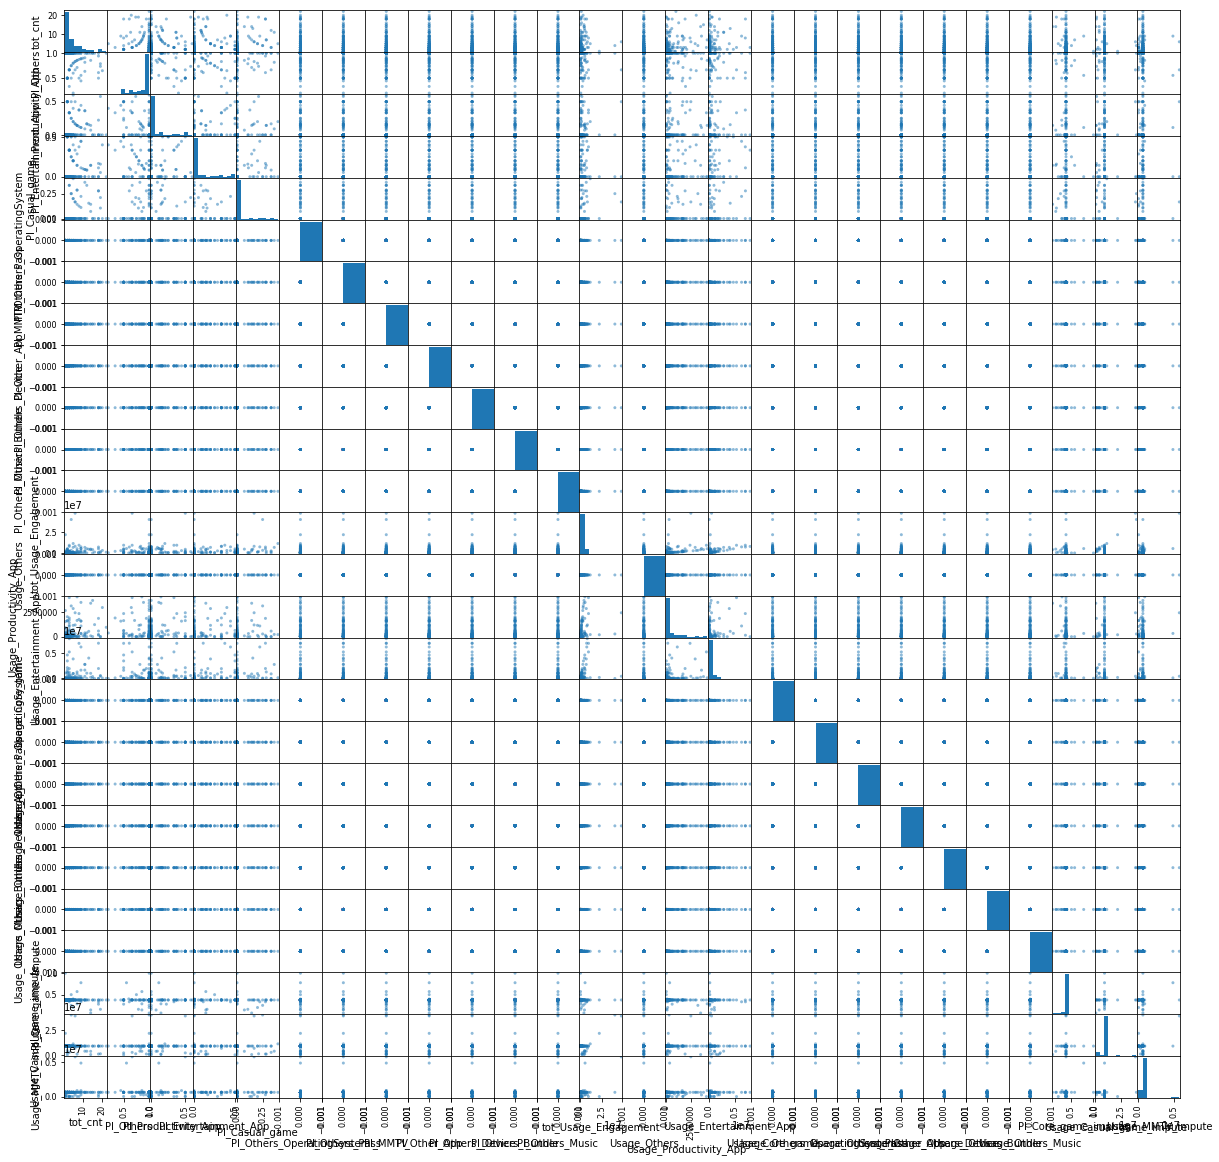

In [237]:
numeric_data = data_final.select(feat_cols).toPandas()

axs = pd.plotting.scatter_matrix(numeric_data, figsize=(20, 20));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())
plt.show()

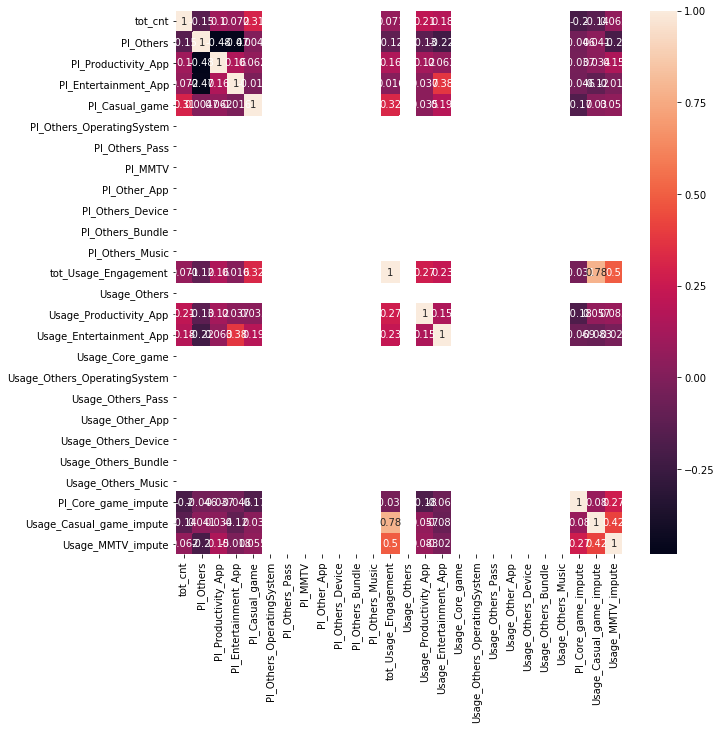

In [238]:
fig, ax = plt.subplots(figsize=(10,10))        
sns.heatmap(numeric_data.corr(), annot=True, ax=ax)

In [174]:
from pyspark.ml.stat import Correlation

tmp = data_final.select(feat_cols)

r1 = Correlation.corr(tmp, feat_cols).head()
print("Pearson correlation matrix:\n" + str(r1[0]))

r2 = Correlation.corr(data_final.select(feat_cols), feat_cols, "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Py4JError: An error occurred while calling z:org.apache.spark.ml.stat.Correlation.corr. Trace:
py4j.Py4JException: Method corr([class org.apache.spark.sql.Dataset, class java.util.ArrayList, class java.lang.String]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:318)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:339)
	at py4j.Gateway.invoke(Gateway.java:276)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)



In [240]:
len(numeric_data.columns)

26

### select features where correlation < 0.9

In [243]:
# select features where correlation < 0.9
corr = numeric_data.corr() 

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9 or corr.iloc[i,j] <= -0.9:
            if columns[j]:
                columns[j] = False


selected_columns = numeric_data.columns[columns]
selected_columns


Index(['tot_cnt', 'PI_Others', 'PI_Productivity_App', 'PI_Entertainment_App',
       'PI_Casual_game', 'PI_Others_OperatingSystem', 'PI_Others_Pass',
       'PI_MMTV', 'PI_Other_App', 'PI_Others_Device', 'PI_Others_Bundle',
       'PI_Others_Music', 'tot_Usage_Engagement', 'Usage_Others',
       'Usage_Productivity_App', 'Usage_Entertainment_App', 'Usage_Core_game',
       'Usage_Others_OperatingSystem', 'Usage_Others_Pass', 'Usage_Other_App',
       'Usage_Others_Device', 'Usage_Others_Bundle', 'Usage_Others_Music',
       'PI_Core_game_impute', 'Usage_Casual_game_impute', 'Usage_MMTV_impute'],
      dtype='object')

In [245]:
columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [244]:
len(selected_columns)

26

In [211]:
all_labels = list(selected_columns) + ['label_New']
all_labels

['tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'tot_Usage_Engagement',
 'Usage_Others',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Others_Pass',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music',
 'PI_Core_game_impute',
 'Usage_Casual_game_impute',
 'Usage_MMTV_impute',
 'label_New']

In [212]:
data_final = data_final.select(all_labels)
data_final.toPandas().head(5)

,tot_cnt,PI_Others,PI_Productivity_App,PI_Entertainment_App,PI_Casual_game,PI_Others_OperatingSystem,PI_Others_Pass,PI_MMTV,PI_Other_App,PI_Others_Device,...,Usage_Others_OperatingSystem,Usage_Others_Pass,Usage_Other_App,Usage_Others_Device,Usage_Others_Bundle,Usage_Others_Music,PI_Core_game_impute,Usage_Casual_game_impute,Usage_MMTV_impute,label_New
0,3,1.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.375659,8.807797e+06,633544.961538,0
1,18,0.500,0.222222,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.277778,8.807797e+06,633544.961538,0
2,3,1.000,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.375659,8.807797e+06,633544.961538,0
3,8,0.875,0.125000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.375659,8.807797e+06,633544.961538,0
4,12,1.000,0.166667,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.375659,3.674893e+06,633544.961538,0


In [215]:
data_final.groupBy('label_New').count().take(5)

[Row(label_New=1, count=13),
 Row(label_New=2, count=10),
 Row(label_New=0, count=107)]

In [217]:
data_final_numeric = data_final.toPandas()

## distribution plot

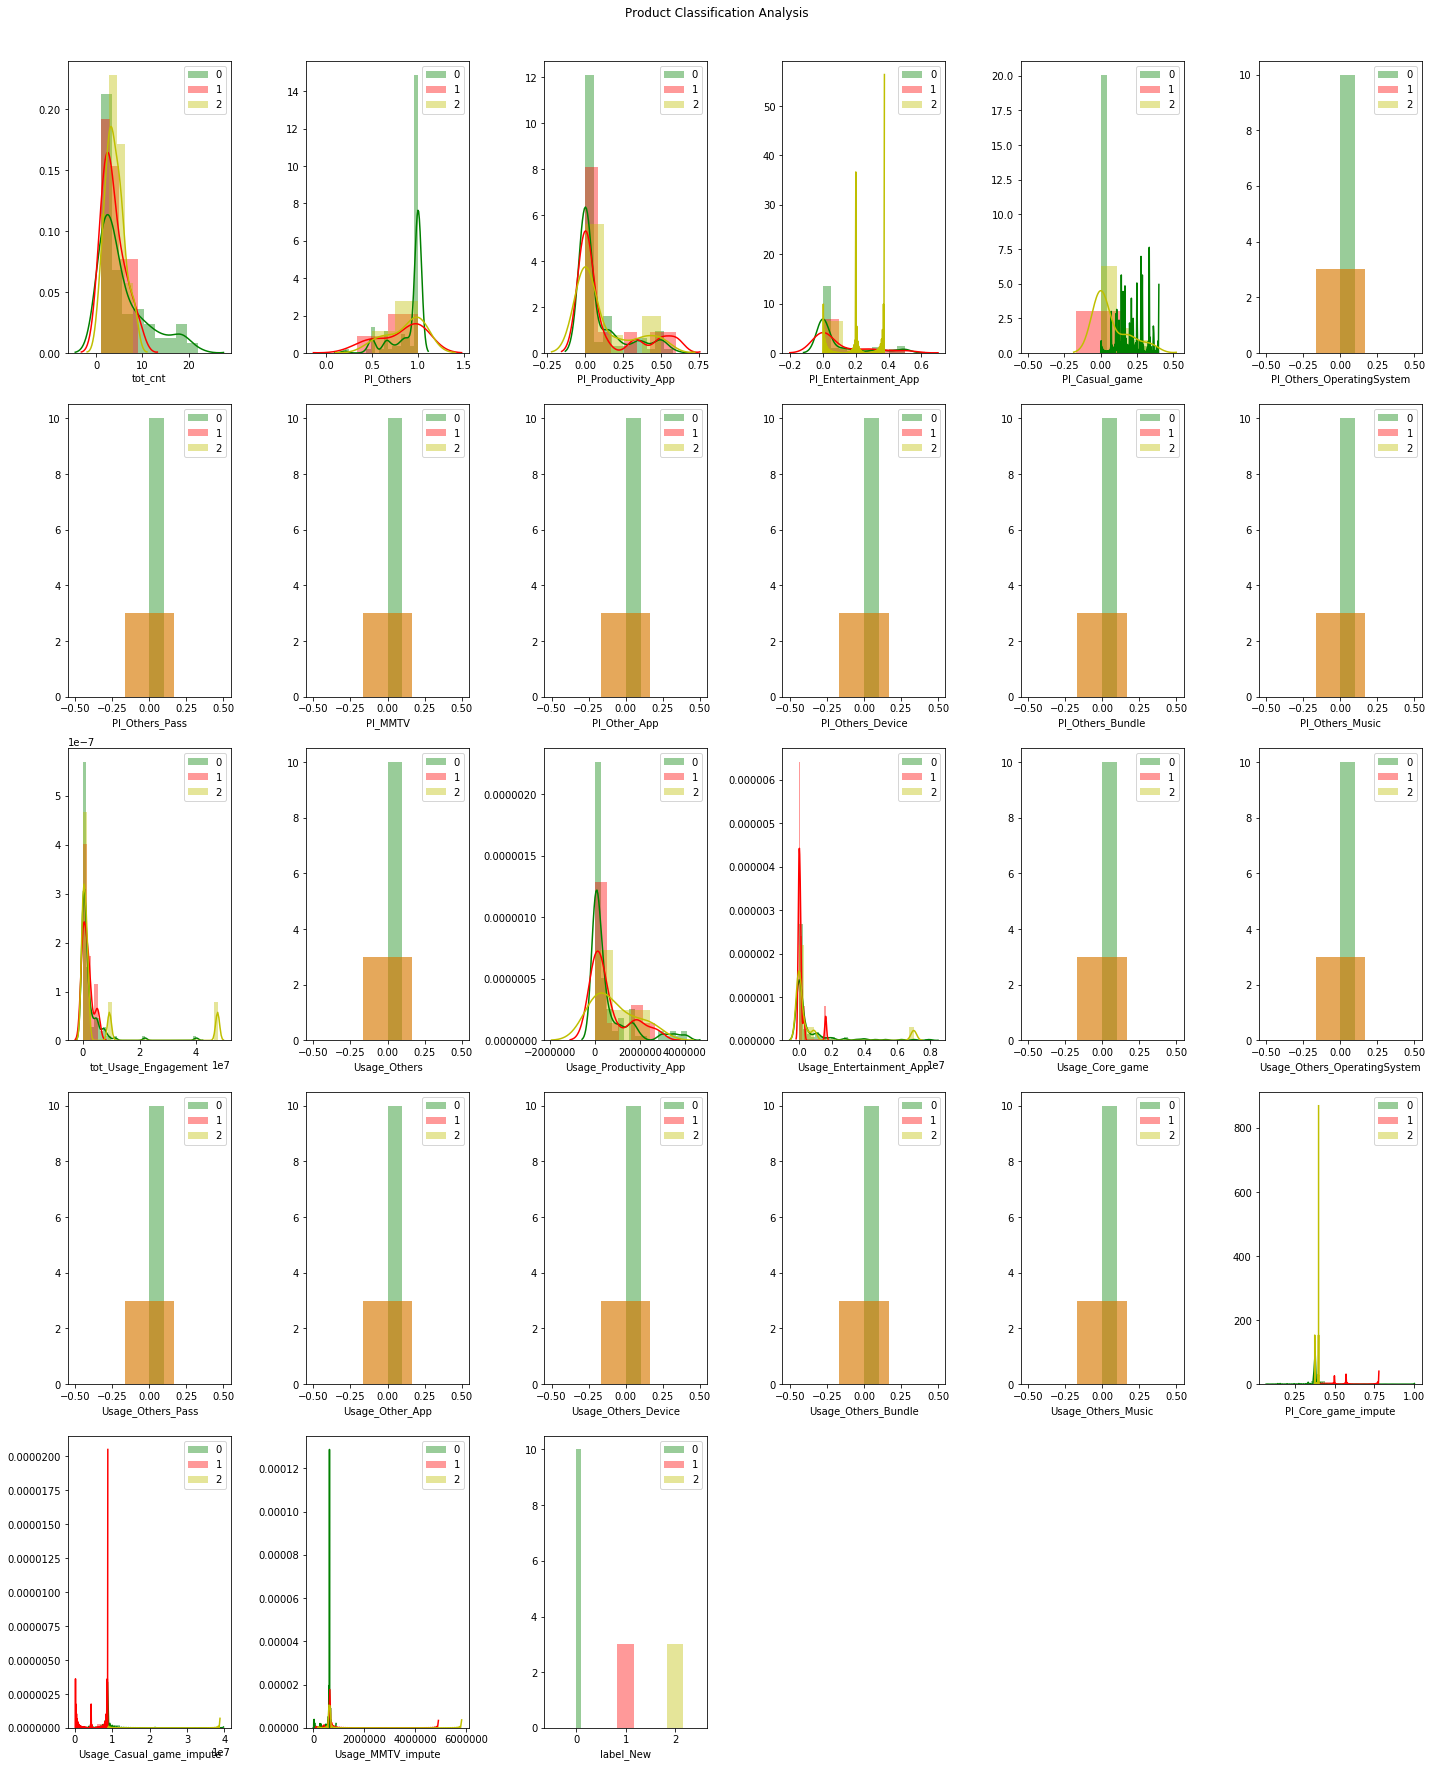

In [221]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_final_numeric.columns:
    plt.subplot(5, 6, j+1)
    j += 1
    sns.distplot(data_final_numeric[i][data_final_numeric['label_New']==0], color='g', label = '0')
    sns.distplot(data_final_numeric[i][data_final_numeric['label_New']==1], color='r', label = '1')
    sns.distplot(data_final_numeric[i][data_final_numeric['label_New']==2], color='y', label = '2')
    plt.legend(loc='best')
fig.suptitle('Product Classification Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [ ]:
## select values based on p-value, null-hypothesis says this combination of features does not affects the independent variable.
## if p-value < threshold then it affects the prediction and hence kept in feature set (i.e. reject the nul-hypothesis)
## 

In [ ]:
## Feature selecture based on regression 

In [252]:
import statsmodels.formula.api as sm
def backwardElimination(Y, x, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        #regressor_OLS = sm.OLS(Y, x).fit()
        regressor_OLS = sm.MNLogit(Y, x).fit(method='bfgs')
        #regressor_OLS.
#         maxVar = np.max(regressor_OLS.pvalues).astype(float)
#         if maxVar > sl:
#             for j in range(0, numVars - i):
#                 if (regressor_OLS.pvalues[j].astype(float) == maxVar):
#                     x = np.delete(x, j, 1)
#                     columns = np.delete(columns, j)
                    
    print (regressor_OLS.summary())
    return x, columns

SL = 0.05
#data_modeled, selected_columns = backwardElimination(data_final_numeric.iloc[:,0:25].values, data_final_numeric.iloc[:,26].values, SL, selected_columns)
data_modeled, selected_columns = backwardElimination(data_final_numeric.iloc[:,26].values,data_final_numeric.iloc[:,0:25].values, SL, selected_columns)

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2154: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2155: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2154: RuntimeWar

         Current function value: nan
         Iterations: 1
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: nan
         Iterations: 1
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: nan
         Iterations: 1
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: nan
         Iterations: 1
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: nan
         Iterations: 1
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: nan
         Iterations: 1
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: nan
         Iterations: 1
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: nan
         Iterations: 1
         Function evaluations: 8
         Gradient evaluat

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2154: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2155: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2154: RuntimeWar

ValueError: need covariance of parameters for computing (unnormalized) covariances

In [248]:
import statsmodels.formula.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        
        maxVar = np.max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

SL = 0.05
data_modeled, selected_columns = backwardElimination(data_final_numeric.iloc[:,0:25].values, data_final_numeric.iloc[:,26].values, SL, selected_columns)


TypeError: object of type 'numpy.int32' has no len()

In [227]:
data_modeled

array([[3.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.75658591e-01, 8.80779719e+06],
       [1.80000000e+01, 5.00000000e-01, 2.22222222e-01, ...,
        0.00000000e+00, 2.77777778e-01, 8.80779719e+06],
       [3.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.75658591e-01, 8.80779719e+06],
       ...,
       [3.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.75658591e-01, 8.80779719e+06],
       [4.00000000e+00, 1.00000000e+00, 2.50000000e-01, ...,
        0.00000000e+00, 3.75658591e-01, 8.80779719e+06],
       [7.00000000e+00, 1.00000000e+00, 1.42857143e-01, ...,
        0.00000000e+00, 3.75658591e-01, 8.80779719e+06]])

In [228]:
len(selected_columns)

26

In [230]:
data_final_numeric.columns[:-1]

Index(['tot_cnt', 'PI_Others', 'PI_Productivity_App', 'PI_Entertainment_App',
       'PI_Casual_game', 'PI_Others_OperatingSystem', 'PI_Others_Pass',
       'PI_MMTV', 'PI_Other_App', 'PI_Others_Device', 'PI_Others_Bundle',
       'PI_Others_Music', 'tot_Usage_Engagement', 'Usage_Others',
       'Usage_Productivity_App', 'Usage_Entertainment_App', 'Usage_Core_game',
       'Usage_Others_OperatingSystem', 'Usage_Others_Pass', 'Usage_Other_App',
       'Usage_Others_Device', 'Usage_Others_Bundle', 'Usage_Others_Music',
       'PI_Core_game_impute', 'Usage_Casual_game_impute', 'Usage_MMTV_impute'],
      dtype='object')

In [231]:
data_final_numeric.columns[26]

'label_New'

In [229]:
from pyspark.ml.stat import ChiSquareTest

r = ChiSquareTest.test(data_final_numeric, data_final_numeric.columns[:-1], data_final_numeric.columns[26]).head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

Py4JJavaError: An error occurred while calling z:org.apache.spark.ml.python.MLSerDe.loads.
: net.razorvine.pickle.PickleException: expected zero arguments for construction of ClassDict (for numpy.core.multiarray._reconstruct)
	at net.razorvine.pickle.objects.ClassDictConstructor.construct(ClassDictConstructor.java:23)
	at net.razorvine.pickle.Unpickler.load_reduce(Unpickler.java:707)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:175)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:99)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:112)
	at org.apache.spark.mllib.api.python.SerDeBase.loads(PythonMLLibAPI.scala:1318)
	at org.apache.spark.ml.python.MLSerDe.loads(MLSerDe.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [ ]:
# final_cols = data_corr.columns + ['tot_cnt','tot_Usage_Engagement','Product_new_group_update']
# final_cols 

In [ ]:
## data1 is the final data set
#data2 = data1.select(final_cols)
#data2.toPandas().head(5)

In [ ]:
data_final.columns 

### undersampling oversampling

In [ ]:
sm = SMOTE(random_state=12, ratio = 'auto', kind = 'regular')

In [ ]:
cols =data_final.columns

In [ ]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

#categoricalColumns = ['Product_new_group_update']
stages = []

#for categoricalCol in categoricalColumns:
#    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
#    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
#    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'label_New', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_Pass',
 'Usage_MMTV',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'tot_cnt',
 'tot_Usage_Engagement']

#assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assemblerInputs =  numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
stages

In [ ]:
data2 =spark.createDataFrame(data_final ) 

In [ ]:
cols = data2.columns + ['label', 'features']
cols

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data2)
df1 = pipelineModel.transform(data2)
#selectedCols = ['label', 'features'] + [cols]
selectedCols = cols

print (selectedCols)

df1 = df1.select(selectedCols)
df1.printSchema()

In [ ]:
pd.DataFrame(df1.take(5), columns=df1.columns).transpose()

# train test split

In [ ]:
train, test = df1.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

In [ ]:
from pyspark.ml.classification import LogisticRegression

#lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10, family='multinomial')
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10, elasticNetParam=0.8)

lrModel = lr.fit(train)

In [ ]:
print("Multinomial coefficients: " + str(lrModel.coefficientMatrix))
print("Multinomial intercepts: " + str(lrModel.interceptVector))

In [ ]:
pred = lrModel.transform(test)

In [ ]:
df_pred = pred.toPandas()
df_pred.head()

In [ ]:
df_pred['label'].value_counts()

In [ ]:
df_pred['prediction'].value_counts()

In [ ]:
from sklearn.metrics import *

In [ ]:
accuracy_score(df_pred['label'],df_pred['prediction'])

In [ ]:
print (classification_report(df_pred['label'],df_pred['prediction']))

In [ ]:
l = (df_pred[1:3]['probability'])*100
l[1]

In [ ]:
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)


# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)

In [ ]:
lrModel.coefficientMatrix[0:0]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients[0])
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()